## Imports

In [19]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [20]:
from google.colab import drive
drive.mount('/content/drive')


!mkdir data_ocr
!mkdir data_ocr/images

!mv /content/drive/MyDrive/Doctor_Handwritten_Datsets/images/* data_ocr/images

Mounted at /content/drive


In [21]:
# Move the CSV file to the data directory (replace 'your_dataset/labels.csv' with the actual path to your CSV file)
!mv /content/drive/MyDrive/Doctor_Handwritten_Datsets/datasets.csv data_ocr

## Dataset splitting

In [22]:
base_path = "data_ocr"
labels_list = []

words = open(f"{base_path}/datasets.csv", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(",")[1] != "err":  # We don't need to deal with errored entries.
        labels_list.append(line)

len(labels_list)

np.random.shuffle(labels_list)

We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [23]:
split_idx = int(0.9 * len(labels_list))
train_samples = labels_list[:split_idx]
test_samples = labels_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(labels_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total Num of training samples: {len(train_samples)}")
print(f"Total Num of  validation samples: {len(validation_samples)}")
print(f"Total Num of  test samples: {len(test_samples)}")

Total Num of training samples: 4501
Total Num of  validation samples: 250
Total Num of  test samples: 251


## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

In [24]:
base_image_path = os.path.join(base_path, "images")


def get_image_paths_and_labels(samples, base_image_path):
    paths = []
    corrected_samples = []
    for sample in samples:
        if 'image,label' in sample:
            continue  # Skip the row with 'image,label'

        imagename, label = sample.strip().split(",")
        img_path = os.path.join(base_image_path, imagename)

        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(label.strip())  # Remove leading/trailing whitespaces including newline

    return paths, corrected_samples



train_img_paths, train_labels = get_image_paths_and_labels(train_samples,base_image_path)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples,base_image_path)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples,base_image_path)

Then we prepare the ground-truth labels.

In [25]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  18
Vocab size:  68


['fungujici',
 'hodina',
 'maso',
 'queen',
 'cizince',
 'Po',
 'Svuj',
 'Uzky',
 'Leos',
 'festival']

Now we clean the validation and the test labels as well.

In [26]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [27]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [28]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


### Putting the utilities together

In [29]:
batch_size = 64
padding_token = 99
image_width = 600
image_height = 64


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


## Prepare `tf.data.Dataset` objects

In [30]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Visualize a few samples

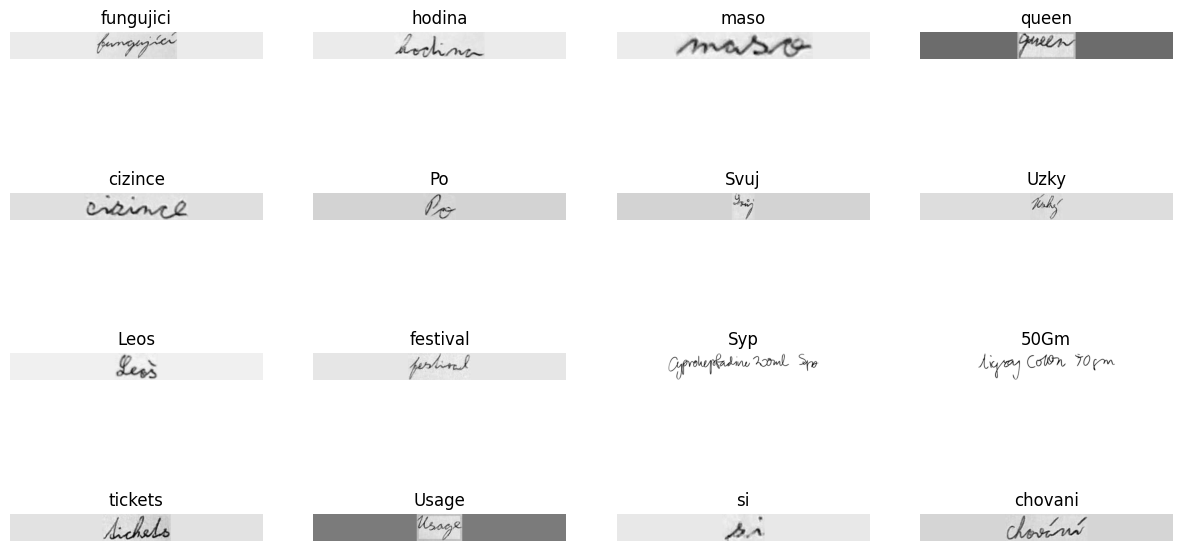

In [31]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [32]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Third conv block (extra depth).
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool3")(x)

    # We have used three max pools with pool size and strides 2.
    # Hence, downsampled feature maps are 8x smaller. The number of
    # filters in the last layer is 128. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 8), (image_height // 8) * 128)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

# Get the model with extra depth.
model = build_model()
model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 600, 64, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 600, 64, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 300, 32, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 300, 32, 64)          18496     ['pool1[0][0]']               
                                                                             

In [33]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

Now, we create a callback to monitor the edit distances.

In [34]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


## Training

Now we are ready to kick off model training.

In [50]:
epochs = 130  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/130
2/2 [==============================] - 1s 30ms/step
Mean edit distance for epoch 1: 18.0000
71/71 [==============================] - 23s 219ms/step - loss: 41.8982 - val_loss: 19.0359
Epoch 2/130
2/2 [==============================] - 0s 18ms/step
Mean edit distance for epoch 2: 18.0000
71/71 [==============================] - 9s 127ms/step - loss: 18.7383 - val_loss: 18.6698
Epoch 3/130
2/2 [==============================] - 0s 18ms/step
Mean edit distance for epoch 3: 18.0000
71/71 [==============================] - 10s 142ms/step - loss: 18.4755 - val_loss: 18.3878
Epoch 4/130
2/2 [==============================] - 0s 26ms/step
Mean edit distance for epoch 4: 18.0000
71/71 [==============================] - 9s 128ms/step - loss: 18.2706 - val_loss: 18.2297
Epoch 5/130
2/2 [==============================] - 0s 18ms/step
Mean edit distance for epoch 5: 18.0000
71/71 [==============================] - 10s 136ms/step - loss: 18.1439 - val_loss: 18.1325
Epoch 6/130
2/2 [=====

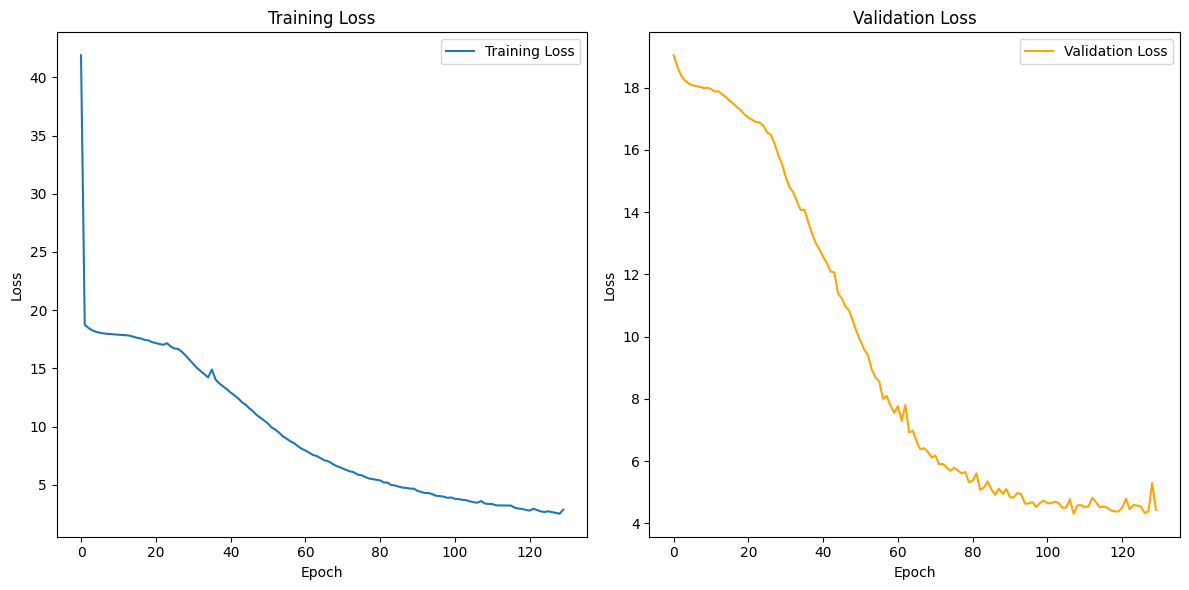

In [51]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Inference

2/2 [==============================] - 0s 25ms/step


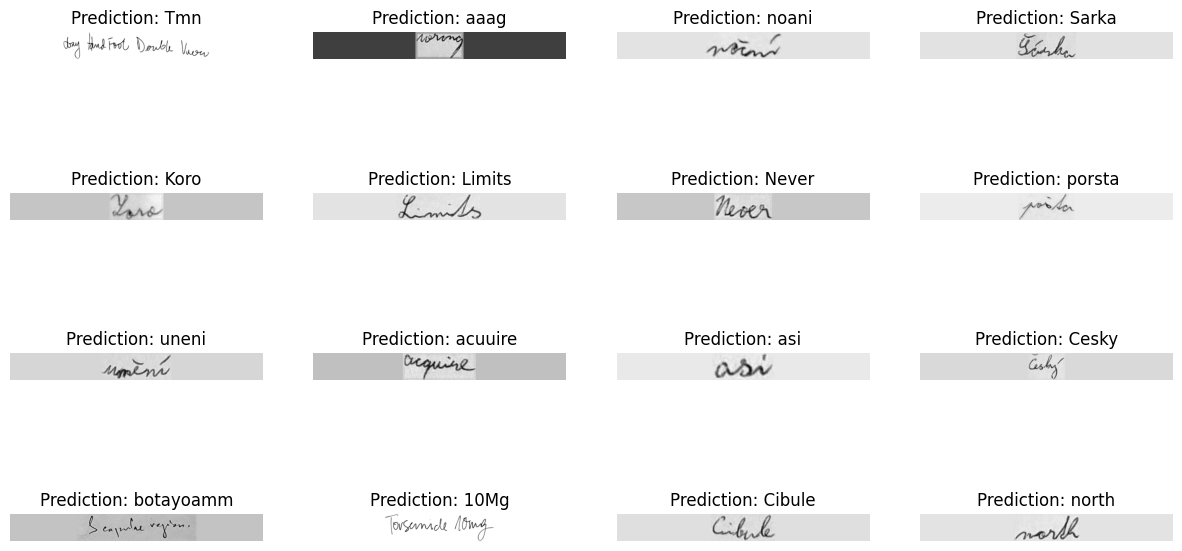

In [52]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

We get better results when the model is trained for at least 100 epochs.